# Response analysis


##### 1. Response expression differential analysis - 
twice: (1) tumor cells and (2) immune cells separately - finds markers across all (protein coding) genes and draw heatmaps. - DONE

##### 2. Response association with clusters analysis - 
Each cluster see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.

##### 3. GEP association with response (1) -
Per program, take all usage values of cells coming from R patients vs. NR patients, and perform Wilcoxon ranksum test.

##### 4. GEP association with response (2) - 
Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between R and NR patients.


In [1]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
# ------- SERVER EXTENSIONS ---------import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
import pickle
# from Bio.Cluster import kcluster
import os
import numpy as np
import yaml
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import pyclustering
import matplotlib.pylab as plt
import seaborn as sb
from os.path import join
plt.rcParams['figure.dpi'] = 400
import seaborn as sns
from utilities.general_helpers import sort_dic, transpose, bold
from general_helpers import create_folder
from scipy.stats import ranksums, wilcoxon
from shutil import copyfile
import matplotlib.pyplot as plt
import random
from utilities.clustering_tools import find_marker_genes_in_cluster, find_markers_in_clusters

##### Loads clinical table to get labels - R/NR

In [8]:
# Loads xlsx files
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)

# takes nly first 46 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:46,:][['Patient id', 'Clinical response']]
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}

# adds CRITERIA response into clinical df
melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')

In [3]:
melanoma_clinical_data.head(5)

,Patient id,Clinical response,response
0,M97,R,R
1,M98,R (had a response in 2016-2019),R
2,M99,NR (PD),NR
3,M100,NR (SD),NR
4,M101,NED- 10/5/20,R


#### Builds response/non_response sample list

In [4]:
response_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'R']['Patient id'].tolist()
non_response_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'NR']['Patient id'].tolist()
no_used_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'not in use for now']['Patient id'].tolist()

print(f'number reponse_samples: {len(response_samples)}')
print(f'number non_reponse_samples: {len(non_response_samples)}')
print(f'number non_reponse_samples: {len(no_used_samples)}')

number reponse_samples: 14
number non_reponse_samples: 25
number non_reponse_samples: 7


#### Loads tumor & immune cohort:

In [5]:
# tumor_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/5.21/cohort_normalized_24.5.21.pkl'
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21.pkl'

# tumor_cohort = pickle.load(open(tumor_path, 'rb'))
cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)
immune_cohort = cohort.filter_cells_by_property('is_immune', True)



#  1. Response expression differential analysis 

(1) tumor cells and (2) immune cells separately - finds markers across all (protein coding) genes and draw heatmaps. - DONE

## Tumor -  Differential analysis

In [10]:
response_samples_indices = [s in response_samples for s in tumor_cohort.samples]
non_response_samples_indices =[s in non_response_samples for s in tumor_cohort.samples]
no_used_samples_indices = [s in no_used_samples for s in tumor_cohort.samples]

print(f'number of cells in response_samples_indices: {sum(response_samples_indices)}')
print(f'number of cells in non_response_samples_indices: {sum(non_response_samples_indices)}')
print(f'number of cells in no_used_samples_indices: {sum(no_used_samples_indices)}')

response_samples_tumor_cells = tumor_cohort[response_samples_indices]
non_response_samples_tumor_cells = tumor_cohort[non_response_samples_indices]

number of cells in response_samples_indices: 14818
number of cells in non_response_samples_indices: 64219
number of cells in no_used_samples_indices: 25898


#### Conduct fisher's exact test to find markers of response in tumor cells:

In [188]:
# from utilities.clustering_tools import find_marker_genes_in_cluster
response_markers = find_marker_genes_in_cluster(response_samples_tumor_cells, non_response_samples_tumor_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)

#### Conduct fisher's exact test to find markers of non-response in tumor cells:

In [ ]:
non_response_markers = find_marker_genes_in_cluster(non_response_samples_tumor_cells, response_samples_tumor_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)

#### Builds heatmap:

In [ ]:
number_of_markers = 50

In [ ]:
# arrange cells indices by mean expression
response_markers_indices = np.array([tumor_cohort.features.index(f) for f in response_markers.iloc[:number_of_markers]['features']])
response_cells_indices = np.flip(np.argsort(response_samples_tumor_cells.counts[:, response_markers_indices].mean(axis=1)))

non_response_markers_indices = [tumor_cohort.features.index(f) for f in non_response_markers.iloc[:number_of_markers]['features']]
non_response_cells_indices = np.flip(np.argsort(non_response_samples_tumor_cells.counts[:, non_response_markers_indices].mean(axis=1)))

In [ ]:
genes_indices = [tumor_cohort.features.index(f) for f in response_markers.iloc[:number_of_markers]['features']] + [tumor_cohort.features.index(f) for f in non_response_markers.iloc[:number_of_markers]['features']]
arr_heatmap = np.concatenate([response_samples_tumor_cells.counts[response_cells_indices][:, genes_indices], non_response_samples_tumor_cells.counts[non_response_cells_indices][:, genes_indices]])
heatmap = np.zeros_like(arr_heatmap)
heatmap[arr_heatmap > 1] = 1
arr_heatmap = scipy.stats.zscore(arr_heatmap, axis=0, ddof=1)

In [ ]:
cmap = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/heatmap/colorbar.pkl', 'rb'))
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 5)

sb_out = sb.heatmap(arr_heatmap.T, vmin=-1, vmax=1, cmap=cmap);
cbar = sb_out.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels([-1, 1])


sb_out.set_xticks([int(response_samples_tumor_cells.number_of_cells/2), response_samples_tumor_cells.number_of_cells+int(non_response_samples_tumor_cells.number_of_cells/2) ]) # <--- set the ticks first
sb_out.set_xticklabels(['response', 'non-response'], rotation='horizontal')


# sb_out.set(xticklabels=[])
sb_out.set(yticklabels=[])
sb_out.tick_params(bottom=False, left=False)

ax.axhline(number_of_markers, color='white')
ax.axvline(response_samples_tumor_cells.number_of_cells, color='white')
ax.set_title(f"tumor cells markers - response/non-response");
# ax.set_xlabel('response            non-response');
ax.set_ylabel('Markers');

In [ ]:
FOLDER_PATH = r'/storage/md_keren/shitay/outputs/response_analysis'
FILE_NAME = r'tumor_cells_marker_heatmap.png'

fig.savefig(join(FOLDER_PATH, FILE_NAME))
response_markers.to_excel(join(FOLDER_PATH, r'response_tumor_markers.xlsx'))
non_response_markers.to_excel(join(FOLDER_PATH, r'non_response_tumor_markers.xlsx'))

## Immune - Differential analysis

In [ ]:
response_samples_indices = [s in response_samples for s in immune_cohort.samples]
non_response_samples_indices =[s in non_response_samples for s in immune_cohort.samples]
no_used_samples_indices = [s in no_used_samples for s in immune_cohort.samples]

print(f'number of cells in response_samples_indices: {sum(response_samples_indices)}')
print(f'number of cells in non_response_samples_indices: {sum(non_response_samples_indices)}')
print(f'number of cells in no_used_samples_indices: {sum(no_used_samples_indices)}')

response_samples_immune_cells = immune_cohort[response_samples_indices]
non_response_samples_immune_cells = immune_cohort[non_response_samples_indices]

##### Conduct fisher's exact test to find markers of response in immune cells:

In [ ]:
# from utilities.clustering_tools import find_marker_genes_in_cluster
immune_response_markers = find_marker_genes_in_cluster(response_samples_immune_cells, non_response_samples_immune_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.05)

##### Conduct fisher's exact test to find markers of response in immune cells:

In [ ]:
immune_non_response_markers = find_marker_genes_in_cluster(non_response_samples_immune_cells, response_samples_immune_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.05)

##### Builds heatmap:

In [ ]:
number_of_markers = 50

In [ ]:
# arrange cells indices by mean expression
response_markers_indices = np.array([immune_cohort.features.index(f) for f in immune_response_markers.iloc[:number_of_markers]['features']])
response_cells_indices = np.flip(np.argsort(response_samples_immune_cells.counts[:, response_markers_indices].mean(axis=1)))

non_response_markers_indices = [immune_cohort.features.index(f) for f in immune_non_response_markers.iloc[:number_of_markers]['features']]
non_response_cells_indices = np.flip(np.argsort(non_response_samples_immune_cells.counts[:, non_response_markers_indices].mean(axis=1)))

In [ ]:
genes_indices = [immune_cohort.features.index(f) for f in immune_response_markers.iloc[:number_of_markers]['features']] + [immune_cohort.features.index(f) for f in immune_non_response_markers.iloc[:number_of_markers]['features']]
arr_heatmap = np.concatenate([response_samples_immune_cells.counts[response_cells_indices][:, genes_indices], non_response_samples_immune_cells.counts[non_response_cells_indices][:, genes_indices]])
heatmap = np.zeros_like(arr_heatmap)
heatmap[arr_heatmap > 1] = 1
arr_heatmap = scipy.stats.zscore(arr_heatmap, axis=0, ddof=1)

In [ ]:
cmap = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/heatmap/colorbar.pkl', 'rb'))
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 5)

sb_out = sb.heatmap(arr_heatmap.T, vmin=-1, vmax=1, cmap=cmap);
cbar = sb_out.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels([-1, 1])


sb_out.set_xticks([int(response_samples_immune_cells.number_of_cells/2), response_samples_immune_cells.number_of_cells+int(non_response_samples_immune_cells.number_of_cells/2) ]) # <--- set the ticks first
sb_out.set_xticklabels(['response', 'non-response'], rotation='horizontal')


# sb_out.set(xticklabels=[])
sb_out.set(yticklabels=[])
sb_out.tick_params(bottom=False, left=False)

ax.axhline(number_of_markers, color='white')
ax.axvline(response_samples_immune_cells.number_of_cells, color='white')
ax.set_title(f"immune cells markers - response/non-response");
# ax.set_xlabel('response            non-response');
ax.set_ylabel('Markers');

In [ ]:
FOLDER_PATH = r'/storage/md_keren/shitay/outputs/response_analysis'
FILE_NAME = r'immune_cells_marker_heatmap.png'

fig.savefig(join(FOLDER_PATH, FILE_NAME))
immune_response_markers.to_excel(join(FOLDER_PATH, r'response_immune_markers.xlsx'))
immune_non_response_markers.to_excel(join(FOLDER_PATH, r'non_response_immune_markers.xlsx'))

# 2. Response association with clusters analysis

For each cluster, see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.


In [6]:
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/summaries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

###### cluster visualizations

In [7]:
df = clusters_barcodes_mapping_df.drop(columns=['index'])
df['Response'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

n_NR = df['Response'].value_counts()['NR']
n_R = df['Response'].value_counts()['R']

In [8]:
clusters = df['Cluster'].unique()

NR_counts = np.zeros(len(clusters))
R_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    responses = df[df['Cluster']==cluster]['Response']
    NR_counts[idx] = sum(responses=='NR')
    R_counts[idx] = sum(responses=='R')


RanksumsResult(statistic=-0.9237604307034011, pvalue=0.3556110610952391)
WilcoxonResult(statistic=22.0, pvalue=0.20361328125)


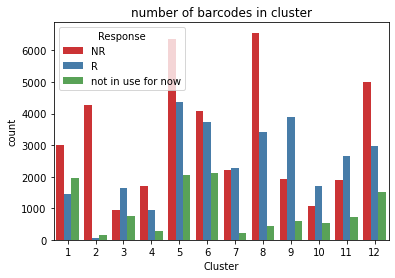

In [9]:
# for idx, (cx, cy) in enumerate(list(zip(NR_counts, R_counts))):
#     print(f'cluster {idx+1} -  NR: {int(cx)}, R: {int(cy)}')

sns.reset_orig() # reset size of figure
ax = sns.countplot(x="Cluster", hue='Response', data=df, palette="Set1").set(title='number of barcodes in cluster')

print()
print(ranksums(R_counts, NR_counts))
print(wilcoxon(R_counts, NR_counts))

##### Normalized by group size (number of barcodes in group - R/NR):

Normalized by number of barcodes in group (R/NR):

RanksumsResult(statistic=0.28867513459481287, pvalue=0.7728299926844475)
WilcoxonResult(statistic=36.0, pvalue=0.85009765625)


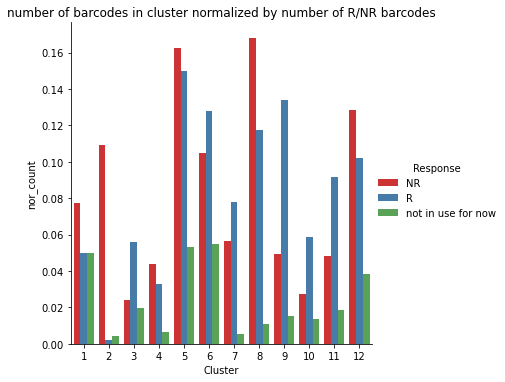

In [10]:
R_nor = R_counts/n_R
NR_nor = NR_counts/n_NR

print('Normalized by number of barcodes in group (R/NR):')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')

count_df = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_R if x['Response']=='R' else x['count']/n_NR ,axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of R/NR barcodes')
    
print()
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

##### Normalized by number of cells in cluster:


RanksumsResult(statistic=-1.4433756729740643, pvalue=0.14891467317876572)
WilcoxonResult(statistic=26.0, pvalue=0.33935546875)


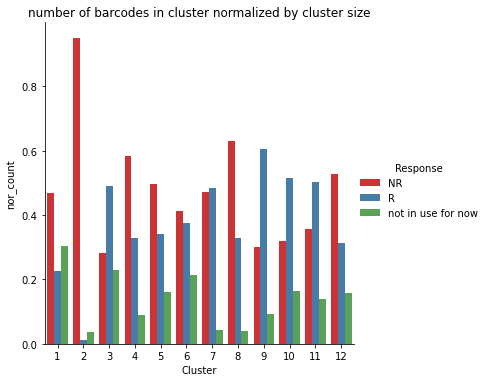

In [11]:
NR_nor = NR_counts/(NR_counts + R_counts)
R_nor = R_counts/(NR_counts + R_counts)

# print('Normalized by number of barcodes in cluster:')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')
    
df_nor_count = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
# df_nor_count = df[df["Response"]!= 'not in use for now'].groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
df_nor_count['nor_count'] = df_nor_count.apply(lambda x: x['count']/df_nor_count[df_nor_count['Cluster']==x['Cluster']]['count'].sum(), axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=df_nor_count, palette="Set1").set(title='number of barcodes in cluster normalized by cluster size')
print()    
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

##### patient fraction over clusters

In [12]:
sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index().drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['index', 'Cluster'])
sample_fractions_df
sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Response'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

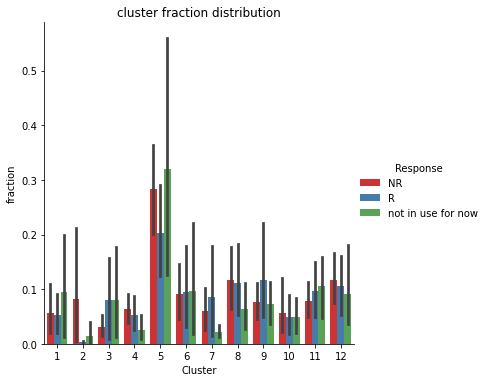

In [13]:
sns.reset_orig()
ax = sns.catplot(kind="bar", x='Cluster', y='fraction', hue='Response', data=sample_fractions_df, palette="Set1").set(title="cluster fraction distribution")

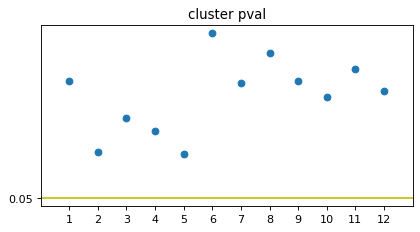

In [15]:
plt.figure(figsize=(6, 3), dpi=80)

pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = sample_fractions_df[sample_fractions_df["Cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    pvals.append([cluster, res])
pvals

pvals = np.array(pvals)
plt.scatter(x=pvals[:,0], y=pvals[:,1],)
ax = plt.plot([0,13],[0.05,0.05], color='y');
plt.xticks(np.arange(1, 13));
plt.yticks([0.05]);
plt.xlim((0,13));
plt.title('cluster pval');

# GEP

In [6]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_26.6.21'
selected_K = 32
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
RUN_RANGE = '32'
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
# normalized_usage_matrix.head()

In [9]:
samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))
df = normalized_usage_matrix.copy()
df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
df['Response'] = df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])


Shows which programs are activity programs, displays the number of samples associated with each program.

In [10]:
activity_programs_df = df.copy()


cell_usage_threshold = 0.2
sample_portion_threshold = 0.2
activity_programs_df.iloc[:,:32] = activity_programs_df.iloc[:,:32] > cell_usage_threshold

sample_counts_df = activity_programs_df.groupby('sample').sum().reset_index().set_index('sample')
samples_num_barcodes = pd.DataFrame(activity_programs_df.groupby('sample')['barcode'].count()).rename(columns={'barcode':'count'})  #.agg({'barcode': ['count']}).reset_index()
sample_fraction_df = sample_counts_df.div(samples_num_barcodes.loc[sample_counts_df.index]['count'], axis=0)

# sample_fraction_df
num_of_program_in_sample = sample_fraction_df > sample_portion_threshold

activity_programs_idx = np.array(num_of_program_in_sample.columns)[num_of_program_in_sample.sum()>1].astype(int)

print(f'Activity programs (more than 2 samples are associated): {activity_programs_idx}')
# num_of_program_in_sample.sum()

Activity programs (more than 2 samples are associated): [ 1  2 10 12 13 14 16 17 21 23 24 29 31 32]


# 3. GEP association with response (1)

Per program, take all usage values of cells coming from R patients vs. NR patients, and perform Wilcoxon ranksum test.

In [11]:
df_r = df[df['Response']=='R']
df_nr = df[df['Response']=='NR']

pvals = np.zeros(selected_K)
for i in range(1, selected_K+1):
    pvals[i-1] = ranksums(df_r[i].values, df_nr[i].values)[1]
    
pvals_df = pd.DataFrame([[v[0], int(v[1])] for v in transpose([pvals, range(1, selected_K+1)])], columns=['pval', 'program'])

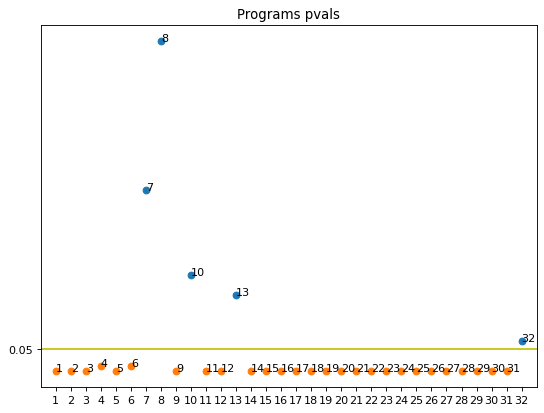

In [22]:
plt.figure(figsize=(8, 6), dpi=80)

pvals = pvals_df[["program", "pval"]].values
small_pvals = pvals[pvals[:,1]<0.05]
big_pvals = pvals[pvals[:,1]>=0.05]


plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1])
plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1])

ax = plt.plot([0,33],[0.05,0.05], color='y')
plt.xticks(np.arange(1, 33));
plt.yticks([0.05]);
plt.xlim((0,33));
plt.title('Programs pvals');

for coord in pvals:
    plt.text(coord[0], coord[1], '{}'.format(int(coord[0])))

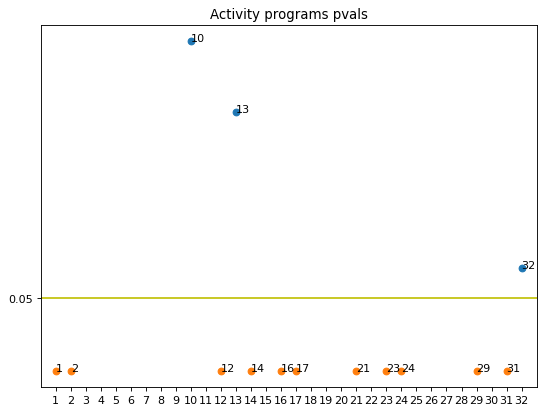

In [21]:
plt.figure(figsize=(8, 6), dpi=80)

int_prog_indxes = activity_programs_idx-1
pvals = pvals_df[["program", "pval"]].values[int_prog_indxes]
small_pvals = pvals[pvals[:,1]<0.05]
big_pvals = pvals[pvals[:,1]>=0.05]


plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1])
plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1])

ax = plt.plot([0,33],[0.05,0.05], color='y')
plt.xticks(np.arange(1, 33));
plt.yticks([0.05]);
plt.xlim((0,33));
plt.title('Activity programs pvals');

for coord in pvals:
    plt.text(coord[0], coord[1], '{}'.format(int(coord[0])))

See usage distribution of activity programs

Usage distribution of activity programs


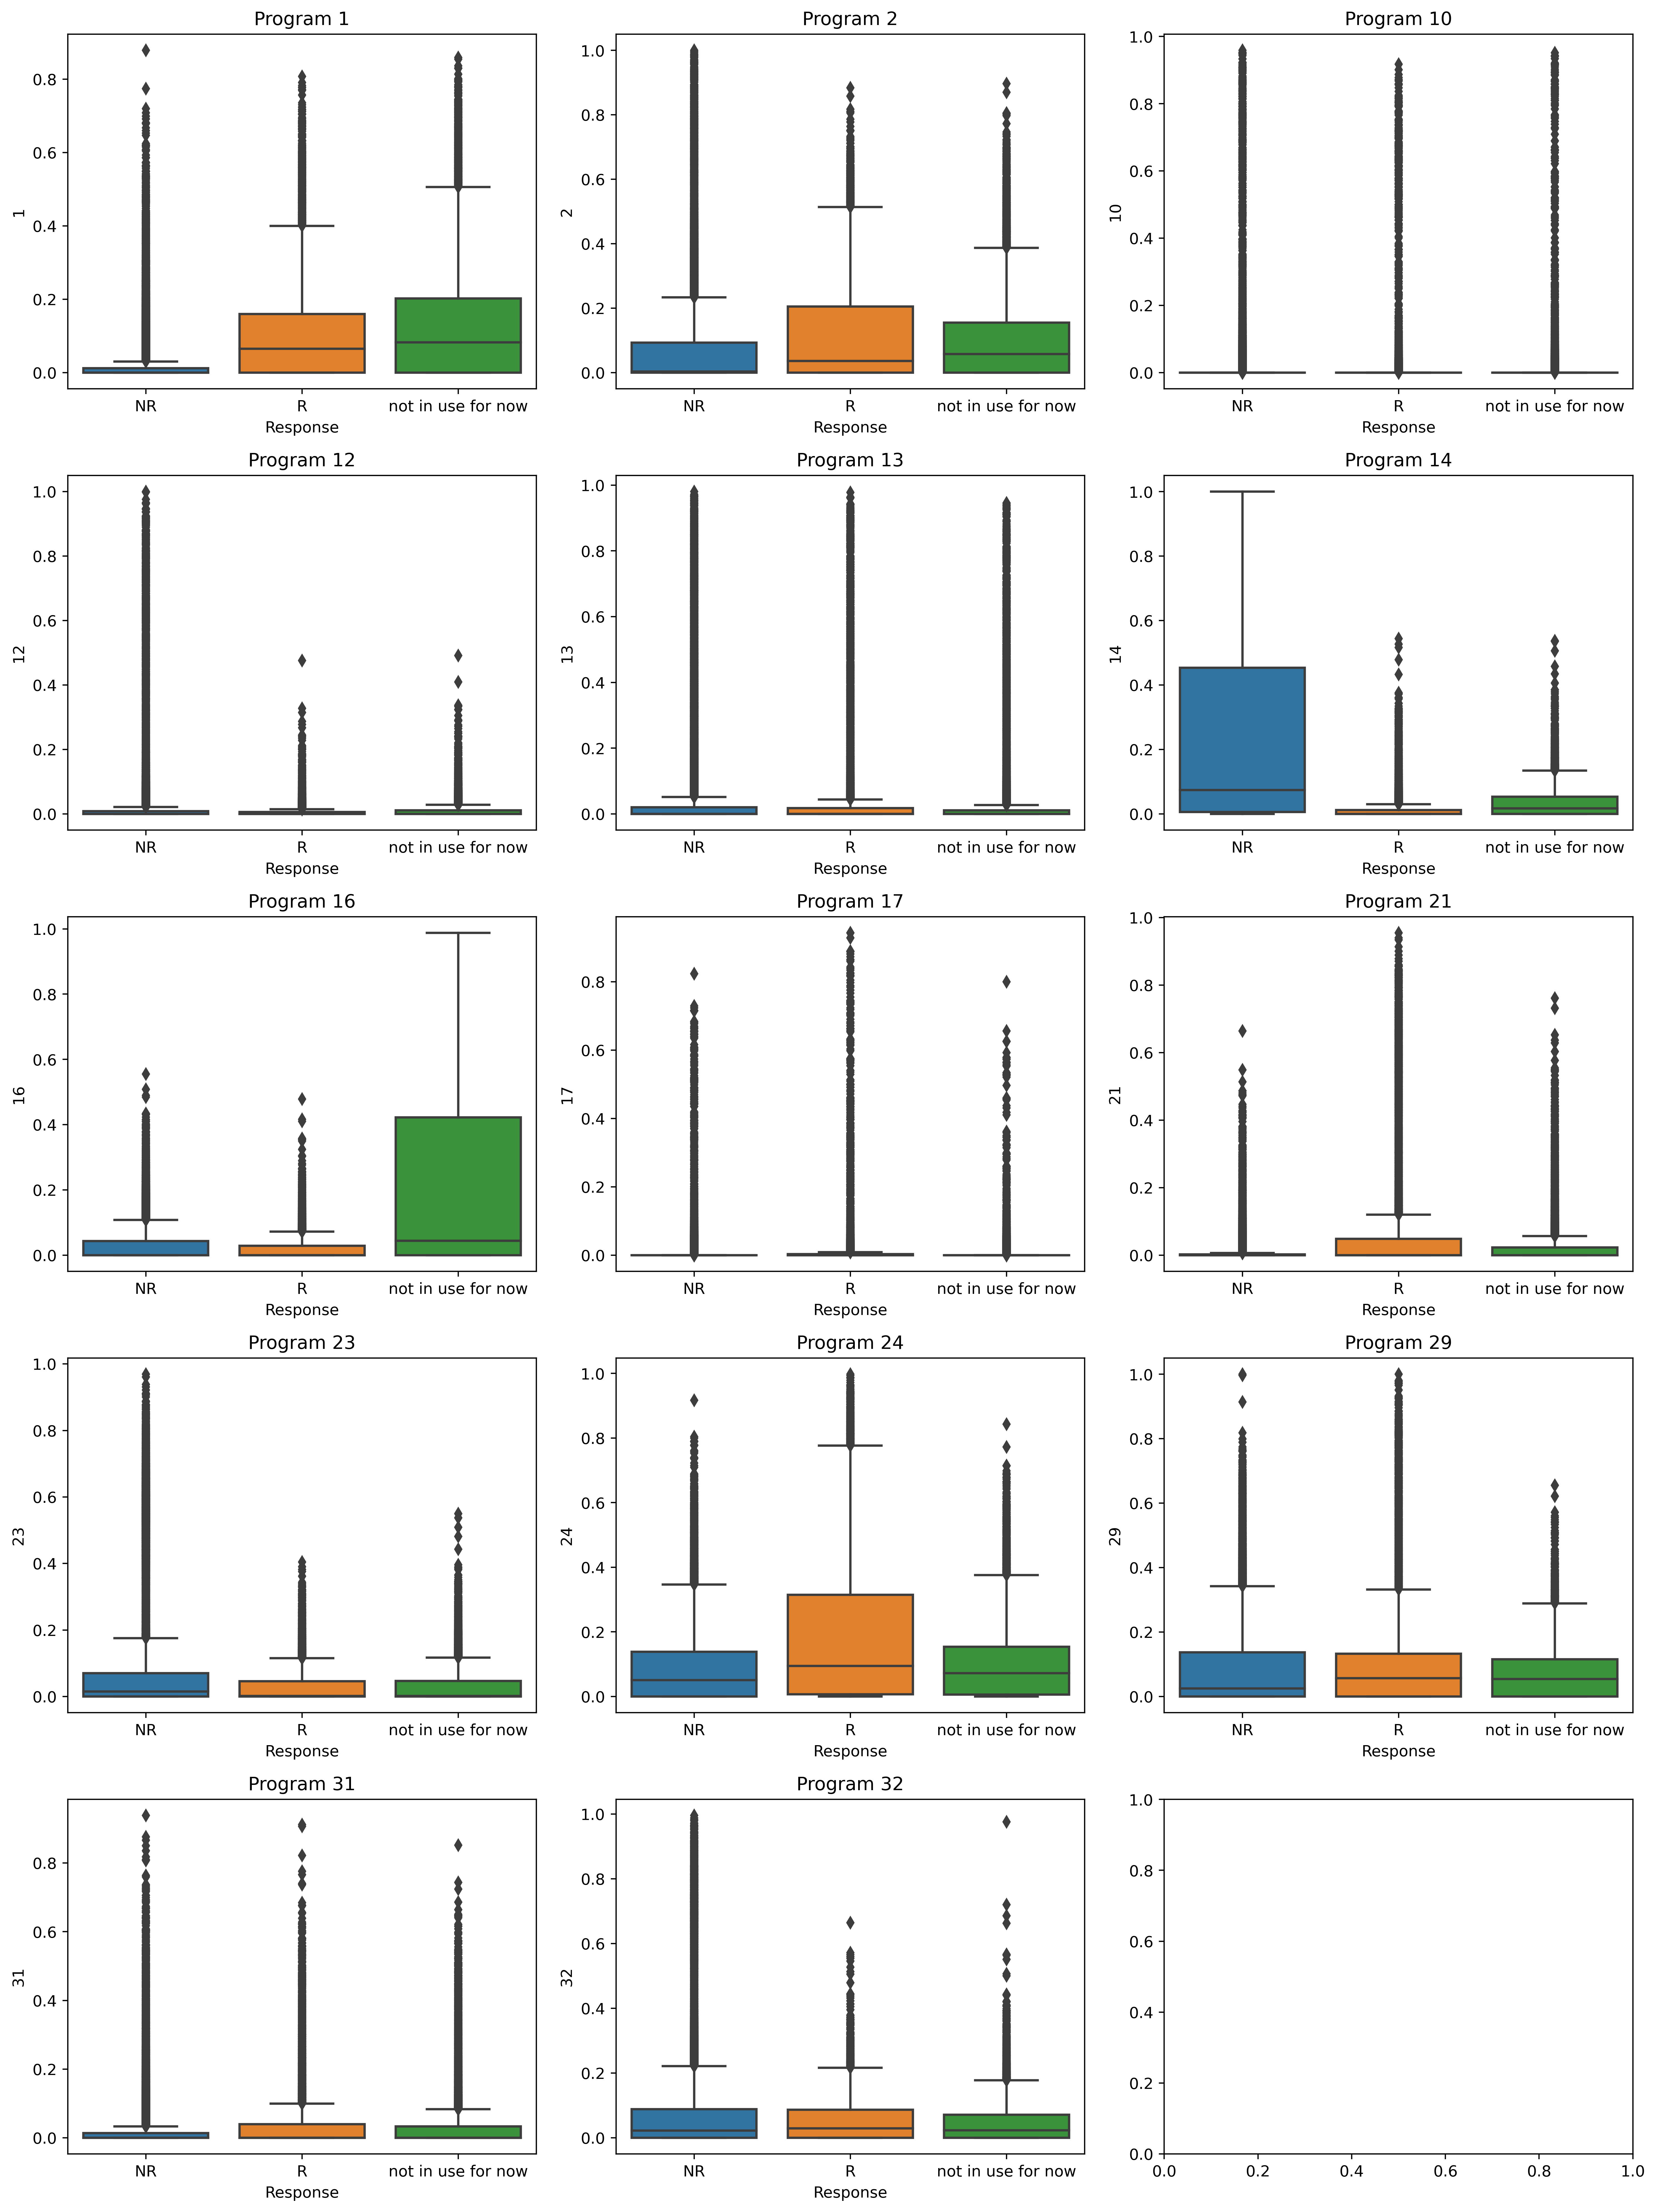

In [24]:
# sns.reset_orig()
import itertools
index = [(x,y) for x in np.arange(11) for y in np.arange(3)]

fig, axs = plt.subplots(int(np.ceil(len(activity_programs_idx)/3)), 3)
fig.set_size_inches(15, 20)
# for i in range(32):
print('Usage distribution of activity programs')
for i, p_idx in enumerate(int_prog_indxes):
    axs[index[i][0], index[i][1]].set_title(f"Program {p_idx+1}")
    sns.boxplot(ax=axs[index[i][0], index[i][1]], y=p_idx+1, x='Response', data=df).set(title=f'Program {p_idx+1}');
plt.tight_layout()


# 4. GEP association with response (2)

Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between R and NR patients.


###### Loads usages:

In [25]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_26.6.21'
selected_K = 32
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
RUN_RANGE = '32'
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
# normalized_usage_matrix.head()

In [26]:
samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))
df = normalized_usage_matrix.copy()
df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
df['Response'] = df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

df_r = df[df['Response']=='R']
df_nr = df[df['Response']=='NR']

##### Assign each cell one program based on the maximal usage value.

In [30]:
r_high_prog = np.argmax(df_r[list(range(1,33))].values, axis=1)+1
nr_high_prog = np.argmax(df_nr[list(range(1,33))].values, axis=1)+1

df_r['associated program'] = r_high_prog
df_nr['associated program'] = nr_high_prog

<ipython-input-30-14cb1492a431>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_r['associated program'] = r_high_prog
<ipython-input-30-14cb1492a431>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nr['associated program'] = nr_high_prog


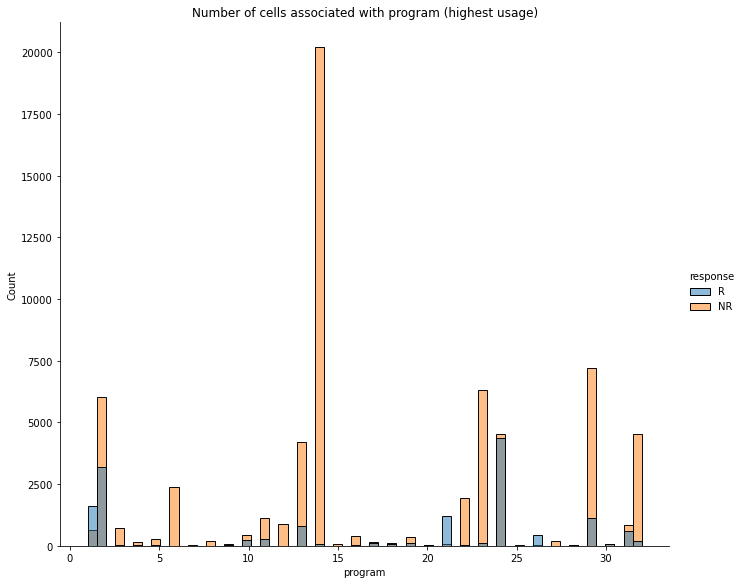

In [31]:
sns.reset_orig() 
ddd = pd.DataFrame(np.concatenate([r_high_prog, nr_high_prog]), columns=['program'])
ddd['response'] = ['R']*len(r_high_prog) + ['NR']*len(nr_high_prog)
sns.displot(data=ddd, x='program', hue='response', common_norm=False,height=8, aspect=1.2).set(title=f'Number of cells associated with program (highest usage)');

Conduct ranksum test:

In [32]:
r_associated_program_count_df = pd.DataFrame(df_r.groupby('sample')['associated program'].value_counts()).rename(columns={'associated program': 'count'}).reset_index()
r_samples = r_associated_program_count_df['sample'].unique()

samples_dic = {}
for sample in r_samples:
#     r_associated_program_count_df[r_associated_program_count_df['sample'==sample]]
    sample_associated_program_df =  r_associated_program_count_df[r_associated_program_count_df['sample']==sample]
    sample_n_barcodes = sum(sample_associated_program_df['count'])
    count_vector = np.zeros(selected_K+1)
    for idx, row in sample_associated_program_df.iterrows():
        count_vector[row['associated program']] = row['count']/sample_n_barcodes
    samples_dic[sample] = count_vector
    
programs_r_patients_usage = {p: [samples_dic[sample][p]  for sample in r_samples] for p in range(1, selected_K+1)}



nr_associated_program_count_df = pd.DataFrame(df_nr.groupby('sample')['associated program'].value_counts()).rename(columns={'associated program': 'count'}).reset_index()
nr_samples = nr_associated_program_count_df['sample'].unique()

samples_dic = {}
for sample in nr_samples:
#     r_associated_program_count_df[r_associated_program_count_df['sample'==sample]]
    sample_associated_program_df =  nr_associated_program_count_df[nr_associated_program_count_df['sample']==sample]
    sample_n_barcodes = sum(sample_associated_program_df['count'])
    count_vector = np.zeros(selected_K+1)
    for idx, row in sample_associated_program_df.iterrows():
        count_vector[row['associated program']] = row['count']/sample_n_barcodes
    samples_dic[sample] = count_vector
    
programs_nr_patients_usage = {p: [samples_dic[sample][p]  for sample in nr_samples] for p in range(1, selected_K+1)}

In [36]:
pvals = np.zeros(selected_K)
for i in range(1, selected_K+1):
    pvals[i-1] = ranksums(programs_nr_patients_usage[i], programs_r_patients_usage[i])[1]
    
    
pvals_df = pd.DataFrame([[v[0], int(v[1])] for v in transpose([pvals, range(1, selected_K+1)])], columns=['pval', 'program'])

# pvals_df['<0.05'] = pvals_df['pval'] < 0.05
# print(bold(f'Number of programs with pval < 0.05: {sum(pvals_df["<0.05"])}'))

# # pd.set_option('display.max_rows', None)
# pd.set_option('display.max_rows', 10)

# pvals_df

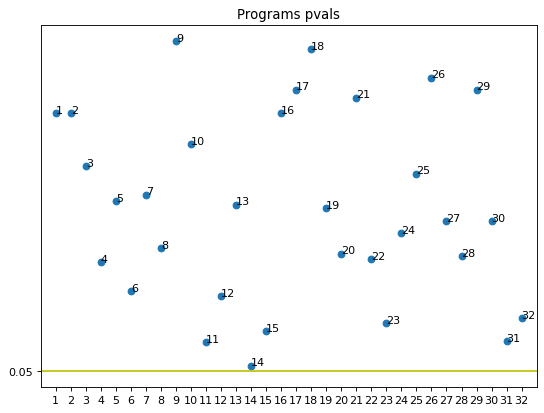

In [37]:
plt.figure(figsize=(8, 6), dpi=80)

pvals = pvals_df[["program", "pval"]].values
small_pvals = pvals[pvals[:,1]<0.05]
big_pvals = pvals[pvals[:,1]>=0.05]


plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1])
plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1])

ax = plt.plot([0,33],[0.05,0.05], color='y')
plt.xticks(np.arange(1, 33));
plt.yticks([0.05]);
plt.xlim((0,33));
plt.title('Programs pvals');

for coord in pvals:
    plt.text(coord[0], coord[1], '{}'.format(int(coord[0])))

Specify program and see the fraction of R/NR sorted:

['NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'NR', 'R', 'R', 'R', 'R', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'R', 'NR', 'NR', 'NR', 'NR', 'R', 'NR', 'NR', 'NR']


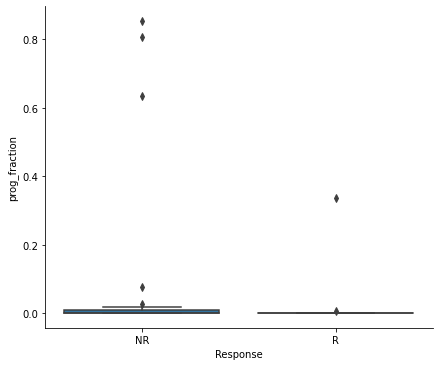

In [38]:
program_idx = 14

patient_fractions = sorted([[x, 'R'] for x in programs_r_patients_usage[program_idx]] + [[x, 'NR'] for x in programs_nr_patients_usage[program_idx]])

sns.reset_orig() # reset size of figure
boxplot_df = pd.DataFrame(patient_fractions, columns=['prog_fraction', 'Response'])
sns.catplot(x="Response", y="prog_fraction", data=boxplot_df, kind="box",height=5, aspect=1.2);


print([x[1] for x in patient_fractions])
# patient_fractions

# Debug

In [2]:
from scipy.stats import rankdata
import scipy.stats as stats
def multipletests_fdr(p_vals, alpha=0.05):
    """
    Test results and p-value correction for multiple tests using Benjamini/Hochberg method.
    :param p_vals: np.array of pvals
    :return: pvals_corrected
    """

    ranked_p_values = rankdata(p_vals)
    pvals_corrected = p_vals * len(p_vals) / ranked_p_values
    pvals_corrected[pvals_corrected > 1] = 1

    return pvals_corrected < alpha, pvals_corrected


def find_marker_genes_in_cluster(cluster_data, other_clusters_data, log_FC_threshold, pval_threshold,
                                 min_pct, min_diff_pct):
    """
    After the clustering process has been done run this function to find marker genes for each cluster.
    The function conducts a Fisher Exact Test for every gene to check whether that gene constitutes a marker
    of one of the clusters. Obviously, we conduct a test per cluster. that means that if we have k clusters and n
    genes we will have k*n tests.
    We test whether the gene in the cluster expresses differently of the other clusters.
    we define expressed as value > 1 (after normalization). and we test the proportion between the number of cells
    expressing each gene compered to all other clusters together.
    because we conduct many statistical test we will correct the pvalues using Benjamini/Hochberg correction
    :param Data_RNAseq: Can be cohort object or singular RNAseq object which all its cells having association to one of the clusters.
    :param clusters_list: cluster in size of number of cells such that each place indicate which cluster corresponds
    to that cell (number of cluster).
    :param min_diff_pct:
    minimum percent difference between the percent of cells expressing the gene in the cluster
    and the percent of cells expressing gene in all other clusters combined.

    :param min_pct: 0.1
    only test genes that are detected in a minimum fraction of cells in either of the two populations.

    Note: Marker defined as gene with pval < pval_thresh and log_FC < log_ratio_threshold
    :return:
    gene names - of all gene markers, ordered by pval_corrected
    gene ids - of all gene markers, ordered by pval_corrected
    pval - of all gene markers, ordered by pval_corrected
    log ratios - of all gene markers, ordered by pval_corrected
    """

    n_cells_in_cluster = len(cluster_data.counts)
    n_cells_in_other_clusters = len(other_clusters_data.counts)
    min_expression_threshold = 1    # for a cell to be counted as a cell that expresses the gene

    df = pd.DataFrame()
    df['features'] = cluster_data.features
    df['gene names'] = cluster_data.gene_names
    df['(1)mean_expression'] = np.mean(cluster_data.counts, axis=0)
    df['(2)mean expression'] = np.mean(other_clusters_data.counts, axis=0)
    df['log_FC'] = np.log2((df['(1)mean_expression'] + 0.01) / (df['(2)mean expression'] + 0.01))
    df['(1)#expressing'] = np.sum((cluster_data.counts > min_expression_threshold), axis=0)
    df['(2)#expressing'] = np.sum((other_clusters_data.counts > min_expression_threshold), axis=0)
    df['(1)%expressing'] = df['(1)#expressing'] / n_cells_in_cluster
    df['(2)%expressing'] = df['(2)#expressing'] / n_cells_in_other_clusters
    df['%expressing_diff'] = df['(1)%expressing'] - df['(2)%expressing']

    # filters not satisfying genes.
    df = df[(df["(1)%expressing"] > min_pct)]
    df = df[(df["%expressing_diff"] > min_diff_pct)]
    df = df[(df['log_FC'] > log_FC_threshold)]
    df = df.sort_values(['log_FC'], ascending=False)

    p_values = []  # before correction
    for index, row in df.iterrows():
        number_of_cells_expressing_gene_in_cluster = row["(1)#expressing"]
        number_of_cells_expressing_gene_in_other_clusters = row["(2)#expressing"]

        oddsratio, pvalue = stats.fisher_exact([[number_of_cells_expressing_gene_in_cluster,
                                                 number_of_cells_expressing_gene_in_other_clusters],
                                                [n_cells_in_cluster - number_of_cells_expressing_gene_in_cluster,
                                                 n_cells_in_other_clusters - number_of_cells_expressing_gene_in_other_clusters]])

        p_values.append(pvalue)

    reject_arr, pvals_corrected = multipletests_fdr(np.array(p_values), alpha=0.05)

    df['pvals'] = pvals_corrected.tolist()
    df = df[df['pvals'] < pval_threshold]

    return df

In [142]:
# find_marker_genes_in_cluster(non_response_samples_immune_cells, response_samples_immune_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)
cluster_data = non_response_samples_immune_cells
other_clusters_data =  response_samples_immune_cells
log_FC_threshold=0.05
pval_threshold=0.05
min_pct=0.1
min_diff_pct=0.1

n_cells_in_cluster = len(cluster_data.counts)
n_cells_in_other_clusters = len(other_clusters_data.counts)
min_expression_threshold = 1    # for a cell to be counted as a cell that expresses the gene

df = pd.DataFrame()
df['features'] = cluster_data.features
df['gene names'] = cluster_data.gene_names
df['(1)mean_expression'] = np.mean(cluster_data.counts, axis=0)
df['(2)mean expression'] = np.mean(other_clusters_data.counts, axis=0)
df['log_FC'] = np.log2((df['(1)mean_expression'] + 0.01) / (df['(2)mean expression'] + 0.01))
df['(1)#expressing'] = np.sum((cluster_data.counts > min_expression_threshold), axis=0)
df['(2)#expressing'] = np.sum((other_clusters_data.counts > min_expression_threshold), axis=0)
df['(1)%expressing'] = df['(1)#expressing'] / n_cells_in_cluster
df['(2)%expressing'] = df['(2)#expressing'] / n_cells_in_other_clusters
df['%expressing_diff'] = df['(1)%expressing'] - df['(2)%expressing']

In [139]:
df = df[(df["(1)%expressing"] > min_pct)]

In [158]:
df.sort_values(['%expressing_diff'], ascending=False)
df[(df["%expressing_diff"] > 0.05)]

,features,gene names,(1)mean_expression,(2)mean expression,log_FC,(1)#expressing,(2)#expressing,(1)%expressing,(2)%expressing,%expressing_diff
74,ENSG00000005022,SLC25A5,1.361568,1.230204,0.145249,19986,13369,0.512251,0.458943,0.053309
334,ENSG00000013441,CLK1,0.548923,0.461063,0.246729,9268,5266,0.237544,0.180776,0.056768
357,ENSG00000015285,WAS,0.738072,0.596710,0.302171,12466,7381,0.319510,0.253381,0.066129
1511,ENSG00000080824,HSP90AA1,1.969967,1.521347,0.370675,24594,15977,0.630357,0.548472,0.081884
1836,ENSG00000089327,FXYD5,2.357033,2.204333,0.096208,28929,20140,0.741465,0.691383,0.050082
2052,ENSG00000096060,FKBP5,0.751687,0.624819,0.262852,11781,7107,0.301953,0.243975,0.057978
2060,ENSG00000096384,HSP90AB1,1.636472,1.271685,0.361337,22306,13975,0.571714,0.479746,0.091968
2123,ENSG00000099860,GADD45B,0.707798,0.560311,0.331831,10487,6203,0.268787,0.212942,0.055845
2185,ENSG00000100100,PIK3IP1,0.568488,0.491259,0.206730,9388,5534,0.240619,0.189976,0.050643
2195,ENSG00000100129,EIF3L,1.079233,0.938644,0.199374,17090,11142,0.438025,0.382492,0.055533


In [141]:
df = df[(df["%expressing_diff"] > min_diff_pct)]
df

,features,gene names,(1)mean_expression,(2)mean expression,log_FC,(1)#expressing,(2)#expressing,(1)%expressing,(2)%expressing,%expressing_diff
17804,ENSG00000204388,HSPA1B,0.567313,0.124682,2.099801,6678,1322,0.171161,0.045383,0.125778
20988,ENSG00000229807,XIST,0.278590,0.054064,2.171435,5004,635,0.128255,0.021799,0.106456


In [ ]:


df = df[(df['log_FC'] > log_FC_threshold)]
df = df.sort_values(['log_FC'], ascending=False)

p_values = []  # before correction
for index, row in df.iterrows():
    number_of_cells_expressing_gene_in_cluster = row["(1)#expressing"]
    number_of_cells_expressing_gene_in_other_clusters = row["(2)#expressing"]

    oddsratio, pvalue = stats.fisher_exact([[number_of_cells_expressing_gene_in_cluster,
                                             number_of_cells_expressing_gene_in_other_clusters],
                                            [n_cells_in_cluster - number_of_cells_expressing_gene_in_cluster,
                                             n_cells_in_other_clusters - number_of_cells_expressing_gene_in_other_clusters]])

    p_values.append(pvalue)

reject_arr, pvals_corrected = multipletests_fdr(np.array(p_values), alpha=0.05)

df['pvals'] = pvals_corrected.tolist()
df = df[df['pvals'] < pval_threshold]

return df